<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/funnel_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we explore the "funnel of hell". This refers to a posterior in which
the mean and variance of a variable are highly correlated, and have a funnel
shape. (The term "funnel of hell" is from [this blog post](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/) by  Thomas Wiecki.)

We illustrate this using a hierarchical Bayesian model for inferring Gaussian means, fit to synthetic data, similar to 8 schools (except we vary the same size and fix the variance). This code is based on [this notebook](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2017/tutorials/aux8_mcmc_tips.html) from Justin Bois.

In [2]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

In [3]:
!pip install -U pymc3>=3.8
import pymc3 as pm
print(pm.__version__)
import arviz as az
print(az.__version__)

3.11.2
0.11.2


In [4]:
import math
import pickle

import numpy as np
import pandas as pd
import scipy.stats as st
import theano.tensor as tt
import theano

In [5]:
np.random.seed(0)
# Specify parameters for random data
mu_val = 8
tau_val = 3
sigma_val = 10
n_groups = 10

# Generate number of replicates for each repeat
n = np.random.randint(low=3, high=10, size=n_groups, dtype=int)
print(n)
print(sum(n))

[7 8 3 6 6 6 4 6 8 5]
59


In [6]:
# Generate data set
mus = np.zeros(n_groups)
x = np.array([])
for i in range(n_groups):
  mus[i] = np.random.normal(mu_val, tau_val)
  samples = np.random.normal(mus[i], sigma_val, size=n[i])
  x = np.append(x, samples)

print(x.shape)

group_ind = np.concatenate([[i]*n_val for i, n_val in enumerate(n)])

(59,)


In [7]:

with pm.Model() as centered_model:
    # Hyperpriors
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=2.5)
    log_tau = pm.Deterministic('log_tau', tt.log(tau))

    # Prior on theta
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=n_groups)
    
    # Likelihood
    x_obs = pm.Normal('x_obs',
                       mu=theta[group_ind],
                       sd=sigma_val,
                       observed=x)


np.random.seed(0)
with centered_model:
    centered_trace = pm.sample(10000, chains=2)
    
pm.summary(centered_trace).round(2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 39 seconds.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6086240934009718, but should be close to 0.8. Try to increase the number of tuning steps.
There were 449 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.703261908881651, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.84,1.54,3.11,8.78,0.09,0.06,300.0,6288.0,1.01
theta[0],8.31,2.96,3.76,14.15,0.24,0.17,116.0,48.0,1.02
theta[1],6.87,2.41,3.01,11.74,0.20,0.14,126.0,69.0,1.01
theta[2],6.32,2.65,1.48,11.69,0.09,0.06,598.0,8827.0,1.00
theta[3],6.54,2.37,2.27,11.40,0.10,0.08,503.0,7735.0,1.01
theta[4],6.53,2.37,2.22,11.24,0.08,0.06,781.0,7799.0,1.01
theta[5],4.78,2.48,-0.25,9.26,0.05,0.05,2244.0,7393.0,1.00
theta[6],4.71,2.76,-0.93,9.62,0.05,0.04,2417.0,7730.0,1.01
theta[7],5.43,2.38,0.66,9.86,0.04,0.03,3364.0,9090.0,1.01
theta[8],3.93,2.65,-1.18,8.52,0.06,0.05,1586.0,1091.0,1.01


In [8]:
with pm.Model() as noncentered_model:
    # Hyperpriors
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=2.5)
    log_tau = pm.Deterministic('log_tau', tt.log(tau))
    
    # Prior on theta
    #theta = pm.Normal('theta', mu=mu, sd=tau, shape=n_trials)
    var_theta = pm.Normal('var_theta', mu=0, sd=1, shape=n_groups)
    theta = pm.Deterministic('theta', mu + var_theta * tau)
    
    # Likelihood
    x_obs = pm.Normal('x_obs',
                       mu=theta[group_ind],
                       sd=sigma_val,
                       observed=x)
    
np.random.seed(0)
with noncentered_model:
    noncentered_trace = pm.sample(1000, chains=2)
    
pm.summary(noncentered_trace).round(2)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [var_theta, tau, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6508565774982737, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.74,1.72,2.45,8.99,0.16,0.12,145.0,55.0,1.04
var_theta[0],0.90,0.90,-0.82,2.58,0.04,0.03,558.0,725.0,1.01
var_theta[1],0.37,0.82,-1.14,1.93,0.03,0.02,940.0,1050.0,1.00
var_theta[2],0.16,0.91,-1.59,1.83,0.04,0.02,642.0,1019.0,1.00
var_theta[3],0.28,0.85,-1.24,1.95,0.03,0.02,702.0,907.0,1.01
var_theta[4],0.30,0.89,-1.25,2.07,0.03,0.02,927.0,968.0,1.00
var_theta[5],-0.36,0.84,-1.86,1.24,0.03,0.02,837.0,867.0,1.00
var_theta[6],-0.40,0.93,-2.26,1.27,0.03,0.02,859.0,857.0,1.00
var_theta[7],-0.10,0.87,-1.74,1.47,0.03,0.02,666.0,859.0,1.00
var_theta[8],-0.65,0.86,-2.25,1.01,0.02,0.02,1228.0,1063.0,1.01


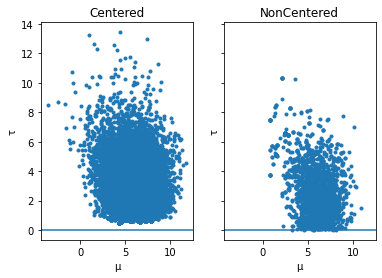

In [9]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['tau'], name='tau')
axs[0].plot(x, y, '.');
axs[0].set(title='Centered', xlabel='µ', ylabel='τ');
axs[0].axhline(0.01)

x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['tau'], name='tau')
axs[1].plot(x, y, '.');
axs[1].set(title='NonCentered', xlabel='µ', ylabel='τ');
axs[1].axhline(0.01)

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


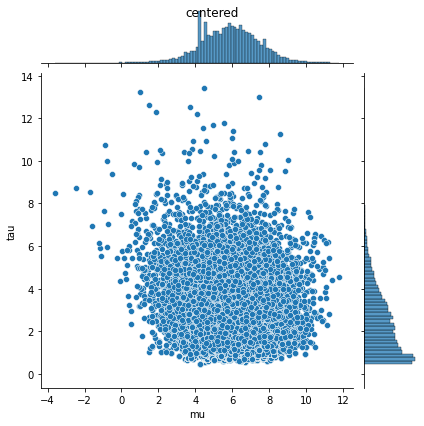

In [10]:
x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['tau'], name='tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('centered')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


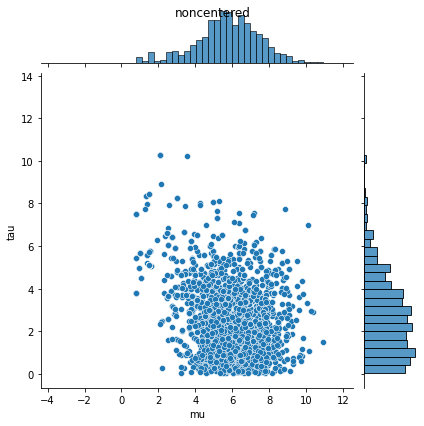

In [11]:
x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['tau'], name='tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('noncentered')
plt.show()

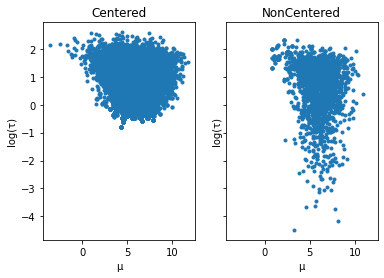

In [12]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['log_tau'], name='log_tau')
axs[0].plot(x, y, '.');
axs[0].set(title='Centered', xlabel='µ', ylabel='log(τ)');

x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['log_tau'], name='log_tau')
axs[1].plot(x, y, '.');
axs[1].set(title='NonCentered', xlabel='µ', ylabel='log(τ)');

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


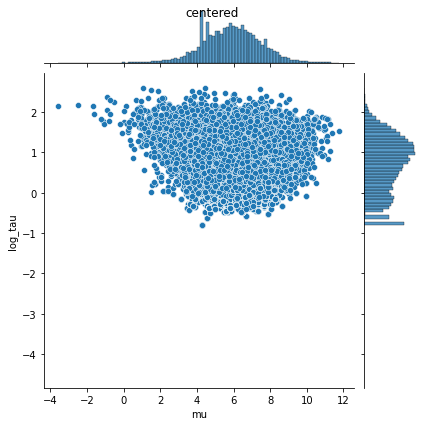

In [13]:
#https://seaborn.pydata.org/generated/seaborn.jointplot.html

x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['log_tau'], name='log_tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('centered')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


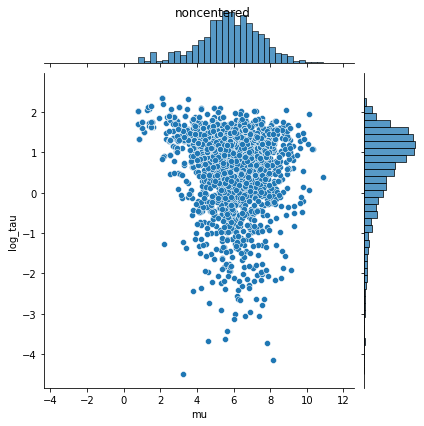

In [14]:
x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['log_tau'], name='log_tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('noncentered')
plt.show()

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


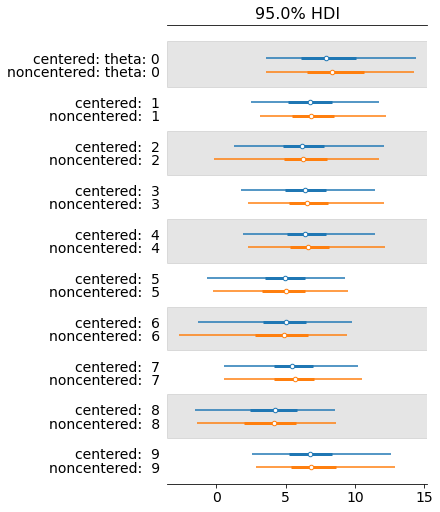

In [18]:
az.plot_forest([centered_trace, noncentered_trace], model_names=['centered', 'noncentered'],
               var_names="theta",
               combined=True, hdi_prob=0.95);